
 <h1><b>        Data Science Project Deliverable 1 + 2


**Name**: Muhammad Farhan Bukhari, Muhammad Tayyab

**Section**: BCS-7C

**Roll Numbers**: 21L-5247, 21L-5340

In [134]:
import pandas as pd
import re
import numpy as np

 <h1><b>Loading the Dataset


In [135]:
df = pd.read_csv("Products_Data.csv")
df

,Brand,Model,Price,Number of Ratings,Display Size,RAM,Battery,Internal Memory
0,Infinix,Zero 40 4G,"Rs.70,000",23,6.78 inches,8GB,500mAh,256GB
1,Samsung,Galaxy Z Flip 6,"Rs.385,000",39,6.7 inches,12GB,4000mAh,512GB
2,Samsung,Galaxy Z Fold 6,"Rs.605,000",45,7.6 inches,12GB,4400mAh,512GB
3,Samsung,Galaxy A05,"Rs.25,000",56,6.7 inches,4GB,5000mAh,64GB
4,Tecno,Phantom V Fold 2 5G,"Rs.370,000",37,7.85 inches,12GB,5750mAh,512GB
...,...,...,...,...,...,...,...,...
1340,gfive,GFive Disco,"Rs 3,199",59,2.4 InchesDisplay,32 MBRAM,3000 mAhBattery,32 MB
1341,gfive,GFive Spark,"Rs 2,325",3 Ratings,1.8 inchesDisplay,32 MBRAM,3000 mAhBattery,32 MB
1342,e-tachi,E-Tachi E888,"Rs 3,749",38,2.8 InchesDisplay,32 MBRAM,3000 mAhBattery,32 MB
1343,sparx,SparX Edge 20,"Rs 5,000",24,6.67 inchesDisplay,8GB+8GB RAMRAM,5000 mAhBattery,256 GB


 <h1><b>Understanding the structure and summary

In [136]:
print(df.describe())
print(df.shape)
print(df.isnull().sum())
print(df.columns)
print(df.dtypes)

          Brand             Model      Price Number of Ratings Display Size  \
count      1345              1345       1345              1345         1345   
unique       63               689        457               204          142   
top     Samsung  Galaxy S24 Ultra  Rs.25,000                 2   6.6 inches   
freq        182                14         34                92          135   

         RAM  Battery Internal Memory  
count   1345     1345            1345  
unique   112       98              70  
top      8GB  5000mAh           128GB  
freq     339      712             340  
(1345, 8)
Brand                0
Model                0
Price                0
Number of Ratings    0
Display Size         0
RAM                  0
Battery              0
Internal Memory      0
dtype: int64
Index(['Brand', 'Model', 'Price', 'Number of Ratings', 'Display Size', 'RAM',
       'Battery', 'Internal Memory'],
      dtype='object')
Brand                object
Model                object
Pri

 <h1><b>Standardization Functions



In [137]:
df.isnull().sum()

,0
Brand,0
Model,0
Price,0
Number of Ratings,0
Display Size,0
RAM,0
Battery,0
Internal Memory,0


In [138]:
def extract_price():
    df['Price'] = df['Price'].replace(
        {'Rs\.': '', 'Rs ': '', ',': '', 'Price Not Available': ''},
        regex=True
    )
    df['Price'] = pd.to_numeric(df['Price'], errors='coerce')

    mean_price = df['Price'].mean()  # Mean strategy
    df['Price'].fillna(mean_price, inplace=True)

    return df


def extract_ram(ram_str):
    if "NORAM" in ram_str.upper():
        return np.nan

    ram_str = ram_str.upper()  # Standardize to uppercase for consistency
    ram_str = ram_str.replace('GRAM', 'GB')

    ram_str = re.sub(r'\+', ',', ram_str)  # Replace '+' with ',' to handle multiple RAM values
    ram_str = re.sub(r'EXTENDEDRAM|DYNAMICRAM|UP TO \d+GB DYNAMIC RAM', '', ram_str)  # Remove virtual/extended RAM info
    ram_str = re.sub(r'[\(\)]', '', ram_str)  # Remove parentheses

    ram_parts = re.split(r'[\/,]', ram_str)

    ram_values = []

    for part in ram_parts:
        # Check if the part is in GB or MB
        gb_match = re.search(r'(\d+)\s*GB', part)
        mb_match = re.search(r'(\d+)\s*MB', part)

        if gb_match:
            ram_values.append(int(gb_match.group(1)))
        elif mb_match:
            ram_values.append(float(mb_match.group(1)) * 0.001)

    if ram_values:
        return max(ram_values)
    else:
        return np.nan


def extract_number_of_ratings():
  df['Number of Ratings'] = df['Number of Ratings'].astype(str).replace(r'\D+', '', regex=True)
  df['Number of Ratings'] = pd.to_numeric(df['Number of Ratings'], errors='coerce')

# Standardize the 'Display Size' column
def extract_display_size():
  df['Display Size'] = df['Display Size'].astype(str).str.extract(r'(\d+\.\d+|\d+)').astype(float)


# Standardize the 'Internal Memory' column
def extract_internal_memory(memory_str):
    if isinstance(memory_str, str):
        memory_str = memory_str.lower().strip()

        memory_str = re.sub(r'rom|extendable|built-in|extended ram|ram|[\(\)]', '', memory_str)
        memory_str = memory_str.replace('tb', '1024gb')
        entries = re.split(r'/|,|\+| ', memory_str.strip())
        first_entry = entries[0] if entries else ''
        try:
            if 'mb' in first_entry:
                value_in_gb = float(first_entry.replace('mb', '').strip()) / 1024
            else:
                value_in_gb = float(first_entry.replace('gb', '').strip())
        except ValueError:
            return float('nan')

        return value_in_gb
    else:
        return float('nan')


def extract_battery(value):
    if value is not None:
        value = str(value)

    if re.match(r"^\d+mAh$", value):
        return int(value.replace("mAh", ""))

    match = re.search(r"(\d+(\.\d+)?)", value)

    if match:
        return float(match.group(1))

    return None # will remove the nan values later as only two entries values have no battery numerical values

df['Battery'] = df['Battery'].apply(extract_battery)
df['Internal Memory'] = df['Internal Memory'].apply(extract_internal_memory)
df['RAM'] = df['RAM'].apply(extract_ram)
extract_number_of_ratings()
extract_display_size()
extract_price()

<ipython-input-138-5367b44ef9c9>:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Price'].fillna(mean_price, inplace=True)


,Brand,Model,Price,Number of Ratings,Display Size,RAM,Battery,Internal Memory
0,Infinix,Zero 40 4G,70000.0,23,6.78,8.000,500.0,256.0
1,Samsung,Galaxy Z Flip 6,385000.0,39,6.70,12.000,4000.0,512.0
2,Samsung,Galaxy Z Fold 6,605000.0,45,7.60,12.000,4400.0,512.0
3,Samsung,Galaxy A05,25000.0,56,6.70,4.000,5000.0,64.0
4,Tecno,Phantom V Fold 2 5G,370000.0,37,7.85,12.000,5750.0,512.0
...,...,...,...,...,...,...,...,...
1340,gfive,GFive Disco,3199.0,59,2.40,0.032,3000.0,32.0
1341,gfive,GFive Spark,2325.0,3,1.80,0.032,3000.0,32.0
1342,e-tachi,E-Tachi E888,3749.0,38,2.80,0.032,3000.0,32.0
1343,sparx,SparX Edge 20,5000.0,24,6.67,8.000,5000.0,256.0


In [139]:
print(df)
df.to_csv('updated_file.csv', index=False)

        Brand                Model     Price  Number of Ratings  Display Size  \
0     Infinix           Zero 40 4G   70000.0                 23          6.78   
1     Samsung      Galaxy Z Flip 6  385000.0                 39          6.70   
2     Samsung      Galaxy Z Fold 6  605000.0                 45          7.60   
3     Samsung           Galaxy A05   25000.0                 56          6.70   
4       Tecno  Phantom V Fold 2 5G  370000.0                 37          7.85   
...       ...                  ...       ...                ...           ...   
1340    gfive          GFive Disco    3199.0                 59          2.40   
1341    gfive          GFive Spark    2325.0                  3          1.80   
1342  e-tachi         E-Tachi E888    3749.0                 38          2.80   
1343    sparx        SparX Edge 20    5000.0                 24          6.67   
1344    gfive       GFive 4G Style    6999.0                 39          2.80   

         RAM  Battery  Inte

In [140]:
df.isnull().sum()

,0
Brand,0
Model,0
Price,0
Number of Ratings,0
Display Size,0
RAM,4
Battery,2
Internal Memory,0


In [141]:
# as there are very less values in battery and ram column which dont make any sense, we can remove them
df = df.dropna(subset=["Battery", "RAM", "Price"])
# Remove rows where 'Price' is an empty string
df.loc[:, 'Price'] = pd.to_numeric(df['Price'], errors='coerce')
df.loc[:, 'Battery'] = pd.to_numeric(df['Battery'], errors='coerce')

 <h1><b>Detecting and resolving outliers by filling with values of removing

In [142]:
# dont need to handle outliers because there is no need to impute the outliers,
# as there are different types of phones from various brands
# which may have very different features from each other, causing the outliers

In [143]:
print(df)
df.to_csv('updated_file.csv', index=False)

        Brand                Model     Price  Number of Ratings  Display Size  \
0     Infinix           Zero 40 4G   70000.0                 23          6.78   
1     Samsung      Galaxy Z Flip 6  385000.0                 39          6.70   
2     Samsung      Galaxy Z Fold 6  605000.0                 45          7.60   
3     Samsung           Galaxy A05   25000.0                 56          6.70   
4       Tecno  Phantom V Fold 2 5G  370000.0                 37          7.85   
...       ...                  ...       ...                ...           ...   
1340    gfive          GFive Disco    3199.0                 59          2.40   
1341    gfive          GFive Spark    2325.0                  3          1.80   
1342  e-tachi         E-Tachi E888    3749.0                 38          2.80   
1343    sparx        SparX Edge 20    5000.0                 24          6.67   
1344    gfive       GFive 4G Style    6999.0                 39          2.80   

         RAM  Battery  Inte

 <h1><b>Normalization of Data

In [144]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import zscore

# Normalize Price, RAM and Battery with Z-score as there are chances that outliers may exist here
df.loc[:, 'Price'] = zscore(df['Price'])
df.loc[:, 'RAM'] = zscore(df['RAM'])
df.loc[:, 'Battery'] = zscore(df['Battery'])

# Normalize columns with Min-Max scaling
scaler = MinMaxScaler()
df.loc[:, ['Number of Ratings', 'Display Size', 'Internal Memory']] = scaler.fit_transform(df[['Number of Ratings', 'Display Size', 'Internal Memory']])

# Optional: You may want to view the normalized DataFrame
print(df.head())

df.to_csv('updated_file.csv', index=False)

     Brand                Model     Price  Number of Ratings  Display Size  \
0  Infinix           Zero 40 4G -0.185713           0.021234      0.863694   
1  Samsung      Galaxy Z Flip 6  2.165063           0.037412      0.853503   
2  Samsung      Galaxy Z Fold 6  3.806875           0.043478      0.968153   
3  Samsung           Galaxy A05 -0.521538           0.054601      0.853503   
4    Tecno  Phantom V Fold 2 5G  2.053122           0.035389      1.000000   

        RAM   Battery  Internal Memory  
0  0.046984 -0.296048         0.023222  
1  0.267772 -0.079742         0.046444  
2  0.267772 -0.055021         0.046444  
3 -0.173803 -0.017940         0.005805  
4  0.267772  0.028411         0.046444  


<ipython-input-144-bc6241ca960f>:12: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.02123357 0.03741153 0.04347826 ... 0.0364004  0.02224469 0.03741153]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[:, ['Number of Ratings', 'Display Size', 'Internal Memory']] = scaler.fit_transform(df[['Number of Ratings', 'Display Size', 'Internal Memory']])


 <h1><b>Data Science Deliverable 2

 <h1><b>Univariate Analysis

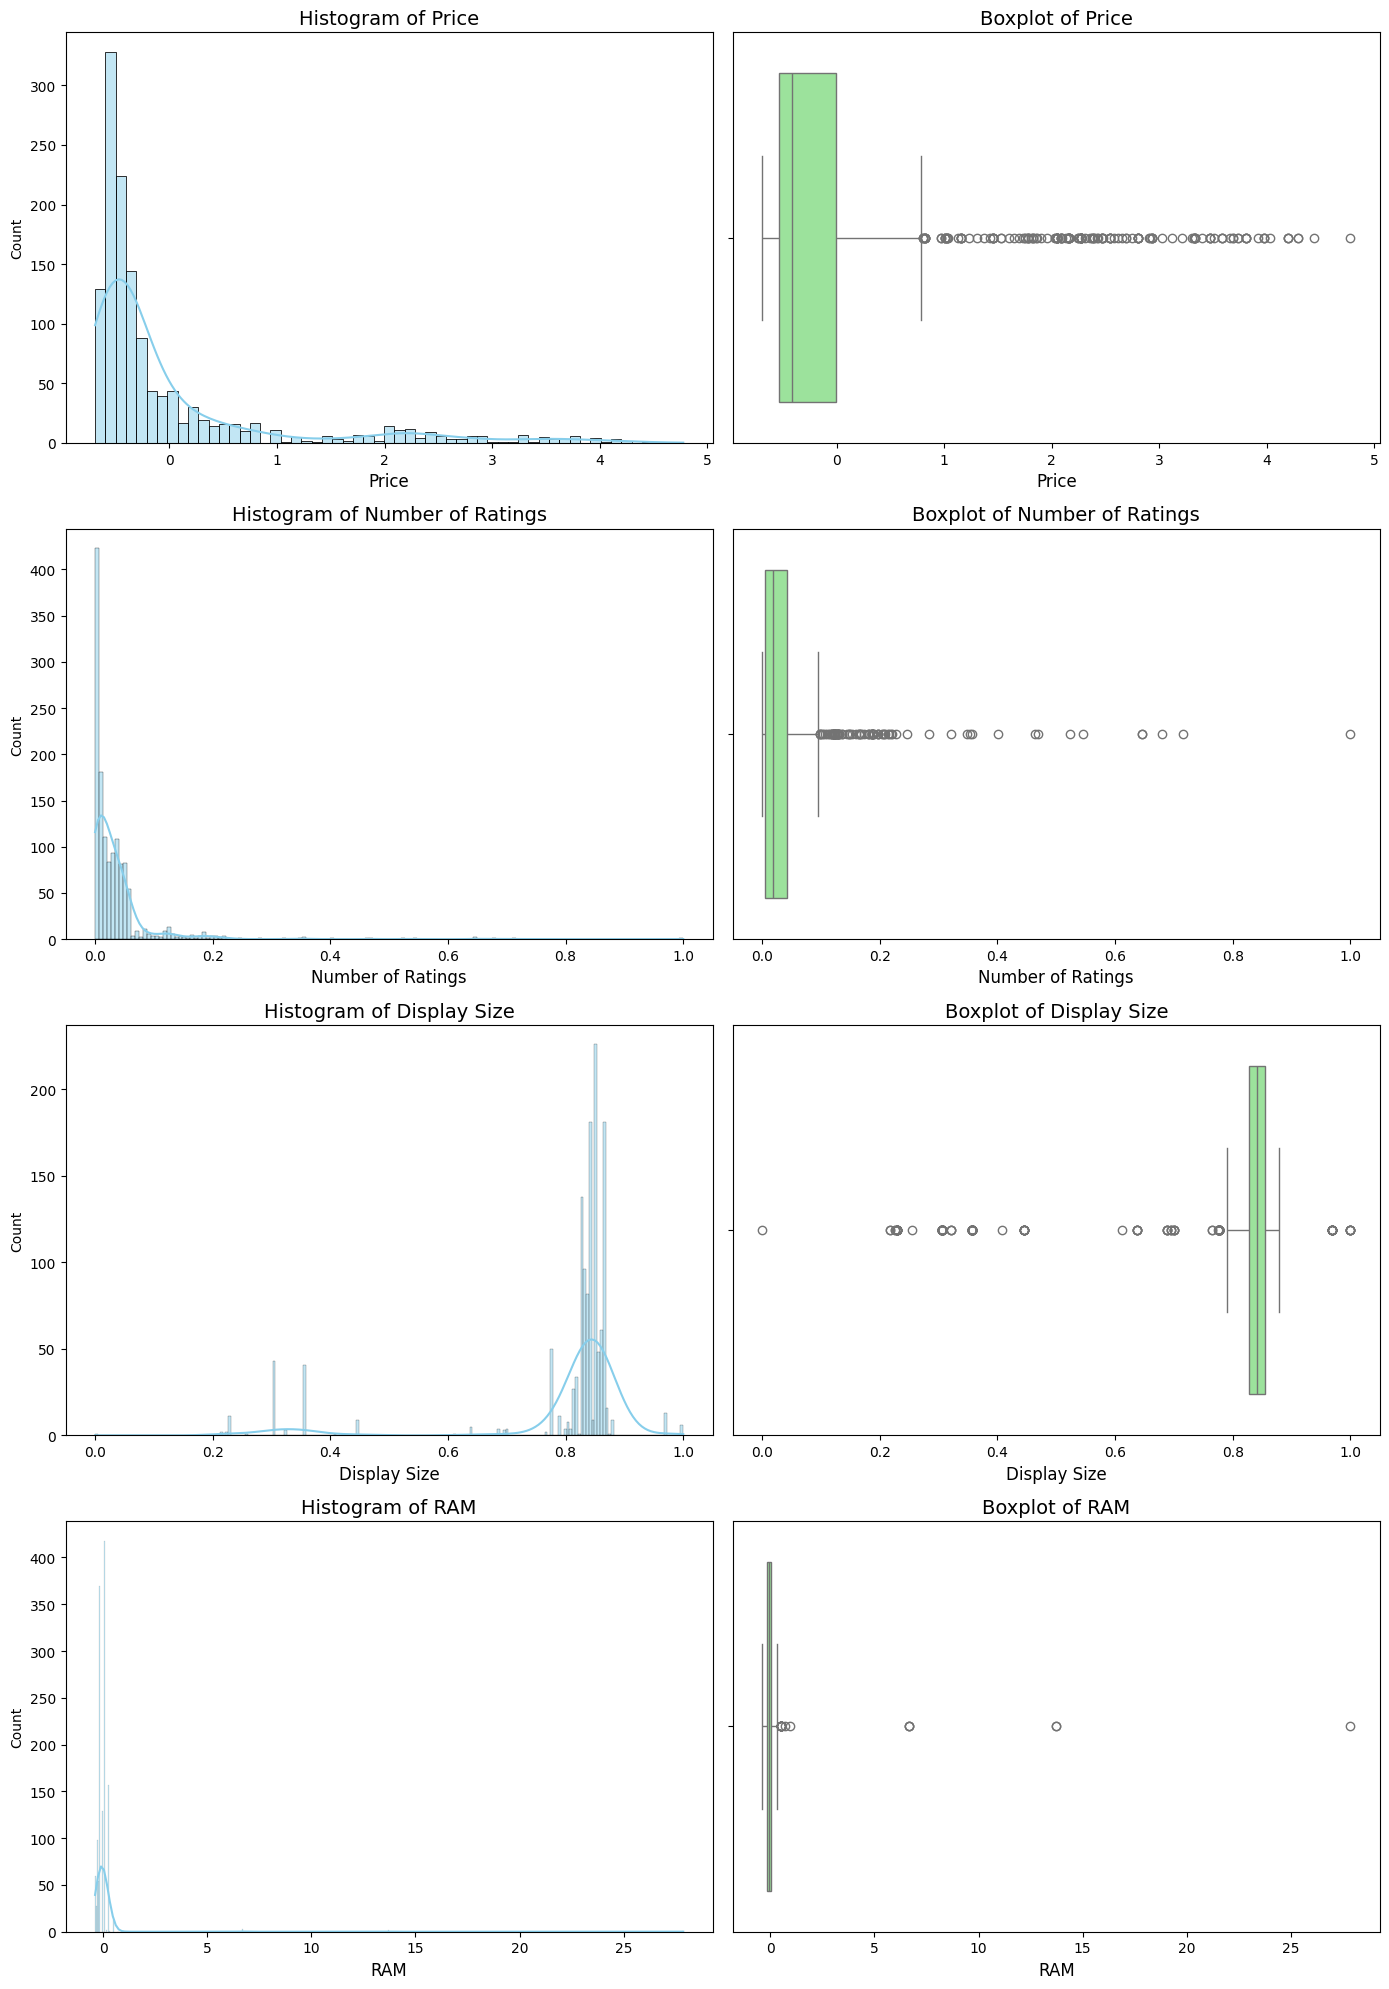

<ipython-input-145-d79d1bca2edb>:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=df[cat], order=df[cat].value_counts().index, palette="viridis")


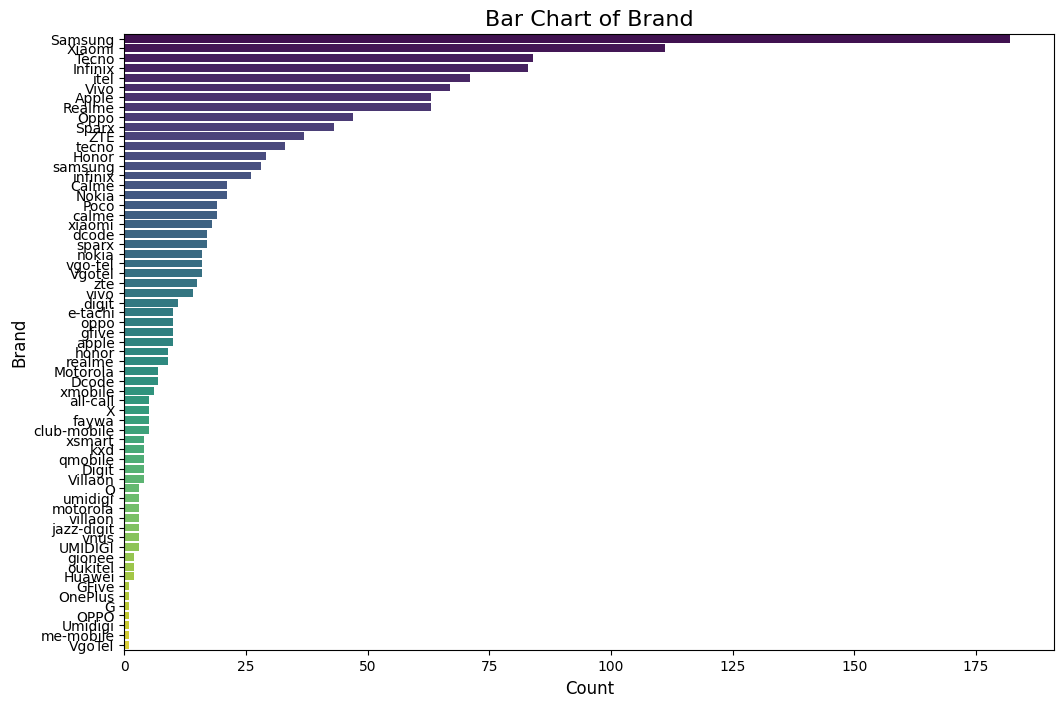

,Price,Number of Ratings,Display Size,RAM
count,1.339000e+03,1339.000000,1339.000000,1.339000e+03
mean,-3.714562e-17,0.034367,0.796831,2.918585e-17
std,1.000374e+00,0.066409,0.149275,1.000374e+00
min,-6.913162e-01,0.000000,0.000000,-3.943703e-01
25%,-5.327321e-01,0.004044,0.828025,-1.738033e-01
50%,-4.095962e-01,0.018200,0.840764,-6.340945e-02
75%,-1.390836e-03,0.041456,0.854140,4.698443e-02
max,4.777037e+00,1.000000,1.000000,2.786624e+01


In [145]:
import matplotlib.pyplot as plt
import seaborn as sns

# Continuous variables for analysis
continuous_vars = ["Price", "Number of Ratings", "Display Size", "RAM"]

# Univariate Analysis: Histograms and Boxplots for continuous variables
fig, axes = plt.subplots(len(continuous_vars), 2, figsize=(14, len(continuous_vars) * 5))

for i, var in enumerate(continuous_vars):
    # Histogram with KDE
    sns.histplot(df[var], kde=True, ax=axes[i, 0], color="skyblue")
    axes[i, 0].set_title(f"Histogram of {var}", fontsize=14)
    axes[i, 0].set_xlabel(var, fontsize=12)

    # Boxplot
    sns.boxplot(x=df[var], ax=axes[i, 1], color="lightgreen")
    axes[i, 1].set_title(f"Boxplot of {var}", fontsize=14)
    axes[i, 1].set_xlabel(var, fontsize=12)

plt.tight_layout()
plt.show()

# Univariate Analysis: Bar chart for categorical variables
categorical_vars = ["Brand"]

for cat in categorical_vars:
    plt.figure(figsize=(12, 8))
    sns.countplot(y=df[cat], order=df[cat].value_counts().index, palette="viridis")
    plt.title(f"Bar Chart of {cat}", fontsize=16)
    plt.xlabel("Count", fontsize=12)
    plt.ylabel(cat, fontsize=12)
    plt.show()

# Summary statistics for continuous variables
summary_stats = df[continuous_vars].describe()
summary_stats


In [146]:
# Calculating summary statistics for all continuous variables
for var in continuous_vars:
    print(f"Statistics for {var}:")
    print(f"Mean: {df[var].mean()}")
    print(f"Median: {df[var].median()}")
    print(f"Mode: {df[var].mode()[0]}")
    print(f"Standard Deviation: {df[var].std()}")
    iqr = df[var].quantile(0.75) - df[var].quantile(0.25)
    print(f"IQR: {iqr}")
    print("\n")

Statistics for Price:
Mean: -3.7145624722335336e-17
Median: -0.4095961840326383
Mode: -0.5215379002128157
Standard Deviation: 1.0003736222809252
IQR: 0.5313412360322874


Statistics for Number of Ratings:
Mean: 0.0343668327706338
Median: 0.01820020222446916
Mode: 0.0010111223458038423
Standard Deviation: 0.06640892176788808
IQR: 0.03741152679474216


Statistics for Display Size:
Mean: 0.796830793966407
Median: 0.840764331210191
Mode: 0.840764331210191
Standard Deviation: 0.14927464901401127
IQR: 0.026114649681528657


Statistics for RAM:
Mean: 2.918584799612062e-17
Median: -0.06340945261109243
Mode: 0.04698442636395
Standard Deviation: 1.0003736222809259
IQR: 0.22078775795008487




In [147]:
# Displaying Outliers

for var in continuous_vars:
    Q1 = df[var].quantile(0.25)
    Q3 = df[var].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = df[(df[var] < lower_bound) | (df[var] > upper_bound)]
    print(outliers[[var]])
    print("\n")


         Price
1     2.165063
2     3.806875
4     2.053122
7     1.008325
8     2.165063
...        ...
1274  1.374001
1279  1.605347
1280  2.053114
1290  1.127729
1324  2.612823

[168 rows x 1 columns]


      Number of Ratings
63             0.122346
67             0.126390
69             0.126390
77             0.147624
92             0.130435
...                 ...
1315           0.347826
1325           0.190091
1327           0.128413
1337           0.352882
1339           0.207280

[90 rows x 1 columns]


      Display Size
2         0.968153
4         1.000000
9         0.968153
14        1.000000
63        0.356688
...            ...
1336      0.305732
1340      0.305732
1341      0.229299
1342      0.356688
1344      0.356688

[202 rows x 1 columns]


            RAM
115    0.488560
1008   0.930135
1011  13.735825
1014   6.670617
1032   6.670617
1048   0.488560
1058  13.735825
1088   0.488560
1092   0.488560
1107   0.488560
1127  27.866242
1134   0.709348
1142   6.670617
115

<h1><b>Bivariate Analysis

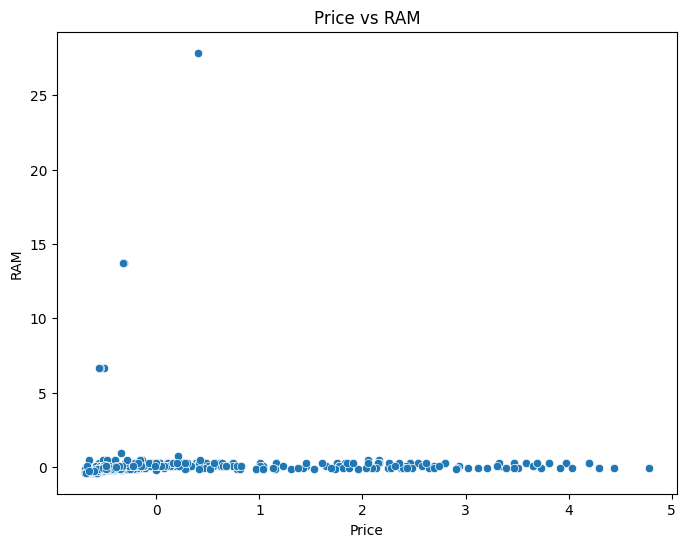

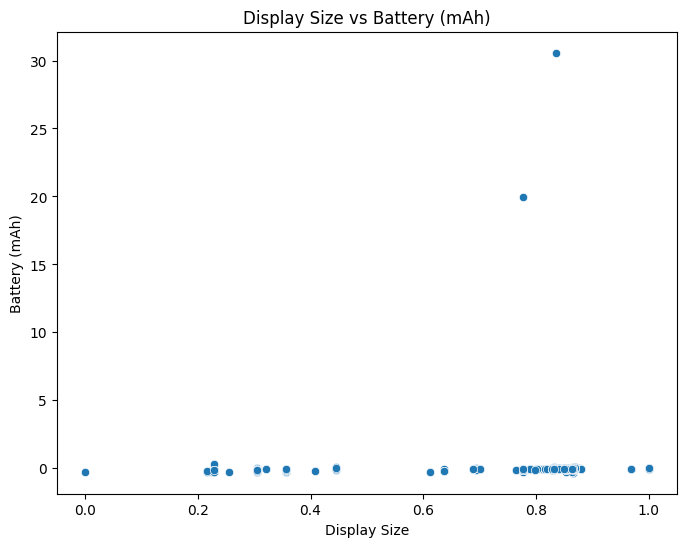

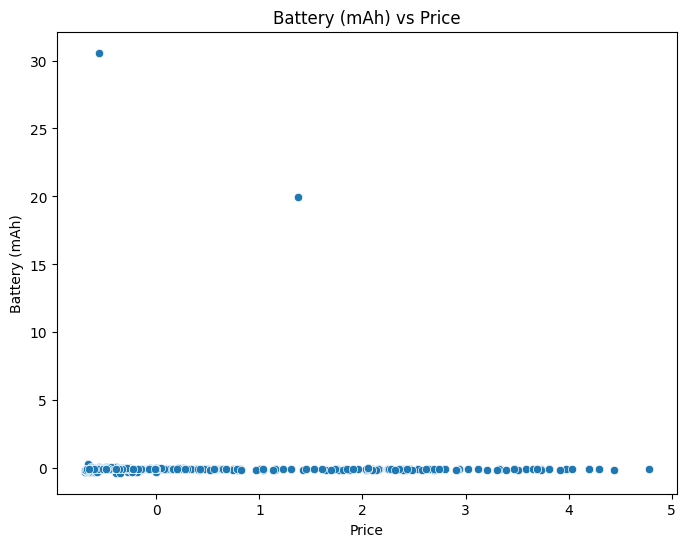

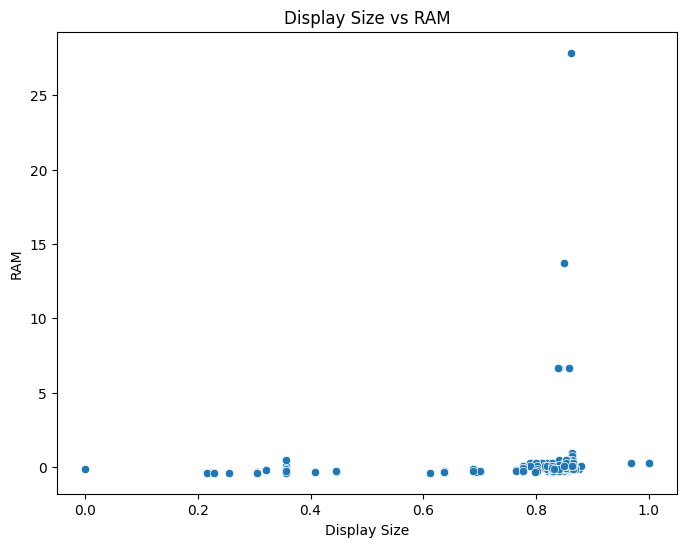

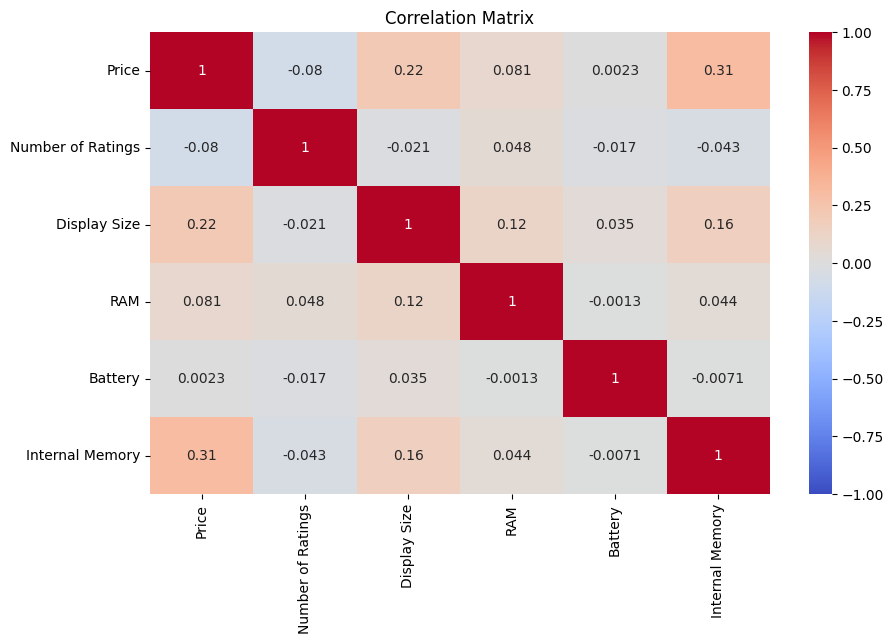

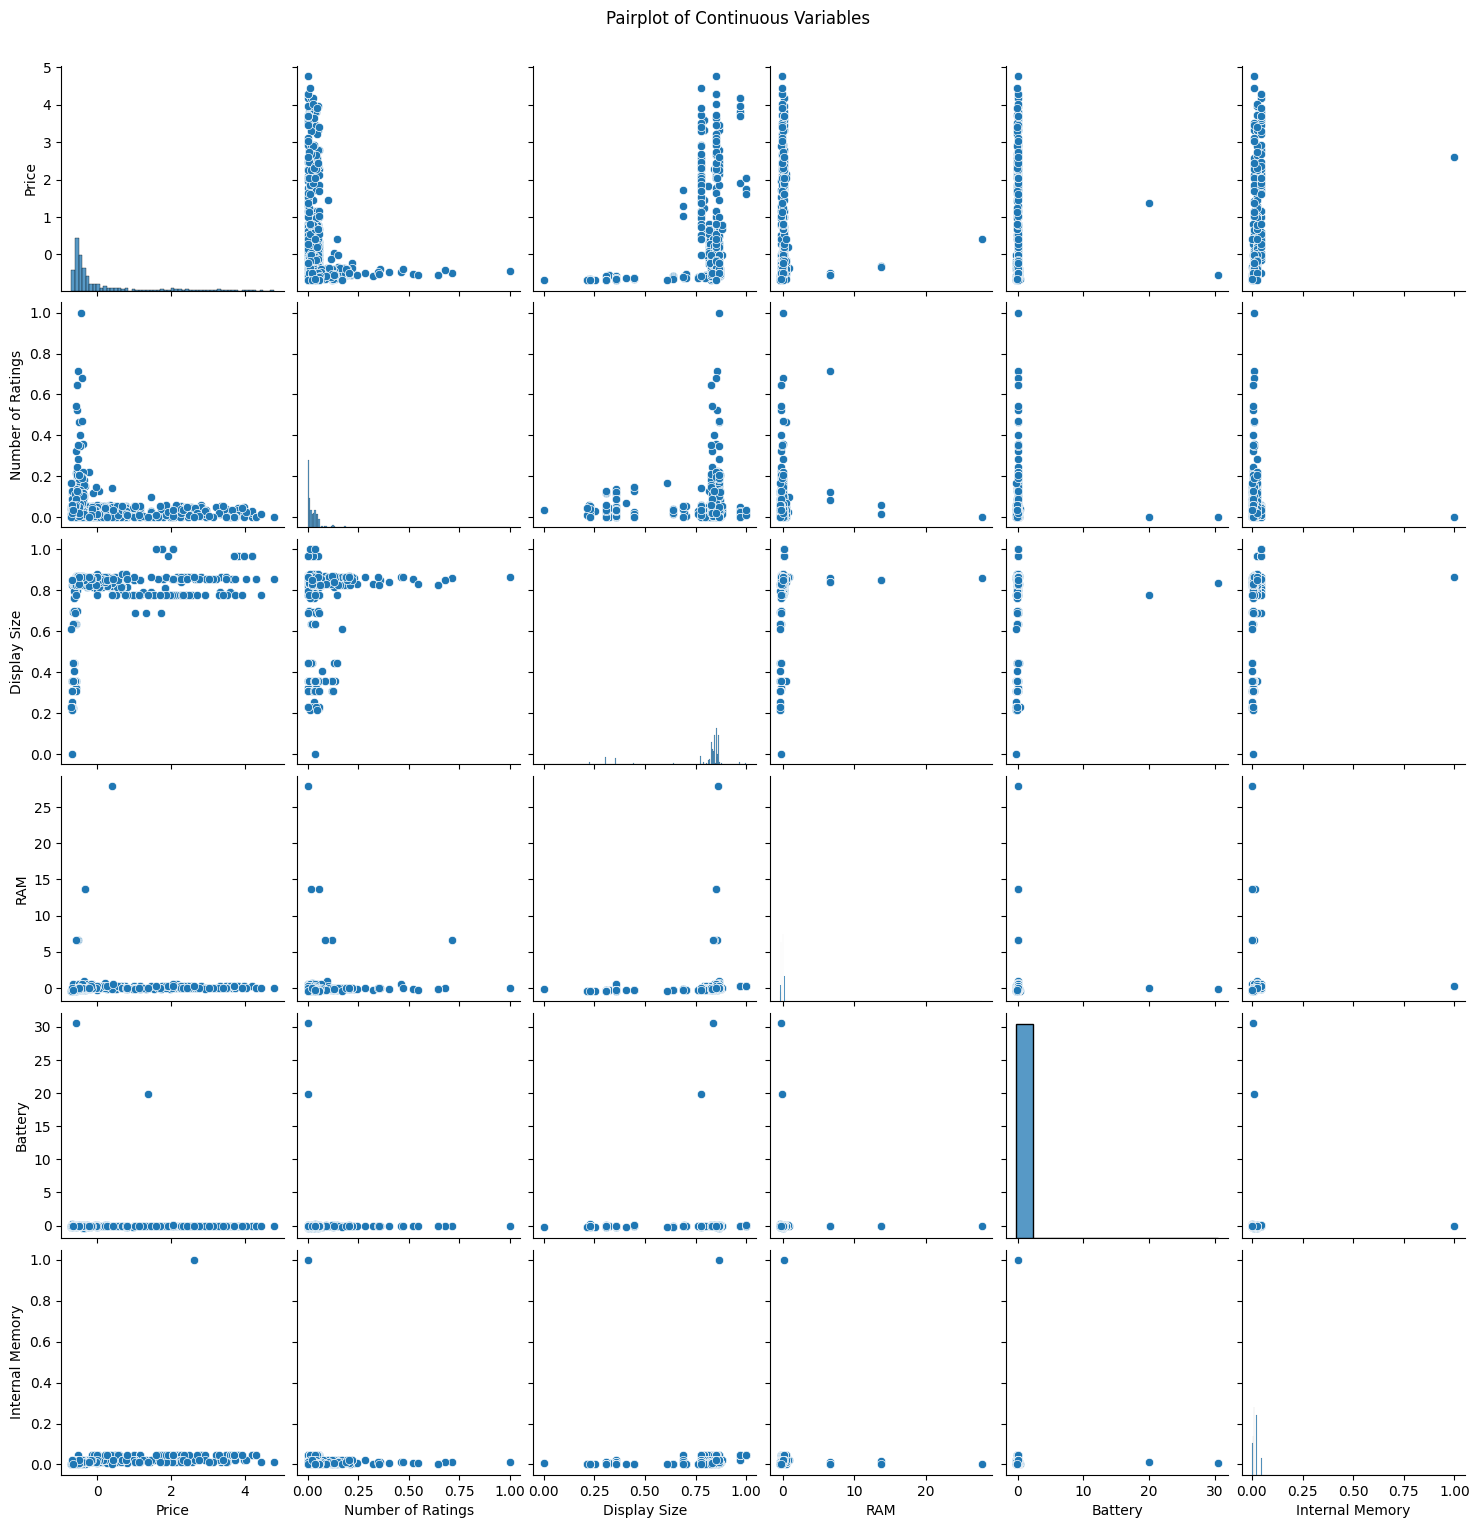

In [148]:
# Scatter plot: Price vs RAM
plt.figure(figsize=(8, 6))
sns.scatterplot(x='Price', y='RAM', data=df)
plt.title('Price vs RAM')
plt.xlabel('Price')
plt.ylabel('RAM')
plt.show()

# Scatter plot: Display Size vs Battery (mAh)
plt.figure(figsize=(8, 6))
sns.scatterplot(x='Display Size', y='Battery', data=df)
plt.title('Display Size vs Battery (mAh)')
plt.xlabel('Display Size')
plt.ylabel('Battery (mAh)')
plt.show()

# Scatter plot: Battery (mAh) vs Price
plt.figure(figsize=(8, 6))
sns.scatterplot(x='Price', y='Battery', data=df)
plt.title('Battery (mAh) vs Price')
plt.xlabel('Price')
plt.ylabel('Battery (mAh)')
plt.show()

# Scatter plot: Display Size vs RAM
plt.figure(figsize=(8, 6))
sns.scatterplot(x='Display Size', y='RAM', data=df)
plt.title('Display Size vs RAM')
plt.xlabel('Display Size')
plt.ylabel('RAM')
plt.show()

# Correlation Matrix for numerical variables
correlation_matrix = df[['Price', 'Number of Ratings', 'Display Size', 'RAM', 'Battery', 'Internal Memory']].corr()
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

# Multivariate Analysis

# Pairplot for all continuous variables
sns.pairplot(df[['Price', 'Number of Ratings', 'Display Size', 'RAM', 'Battery', 'Internal Memory']])
plt.suptitle('Pairplot of Continuous Variables', y=1.02)
plt.show()

<h1><b>Feature Analysis

Correlation with Target (Price):
Number of Ratings   -0.080341
Display Size         0.216910
RAM                  0.080950
Battery              0.002267
Internal Memory      0.305117
Price                1.000000
Name: Price, dtype: float64


<ipython-input-149-8315777a2f9b>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=correlation_with_target.index, y=correlation_with_target.values, palette="Blues_d")


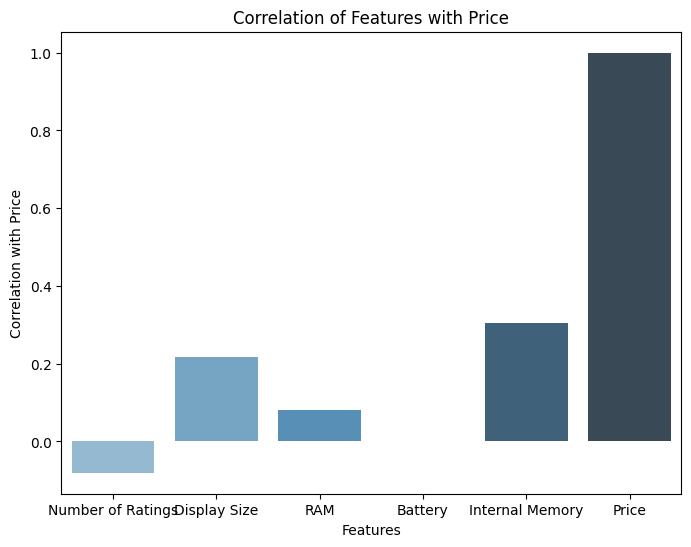


Grouped by Brand:
             mean    median       std
Brand                                
Apple    2.287464  2.374021  1.162086
Calme   -0.642968 -0.637211  0.013893
Dcode   -0.452241 -0.428253  0.063245
Digit   -0.547658 -0.540195  0.032530
G       -0.640942 -0.640942       NaN
...           ...       ...       ...
vnus    -0.615576 -0.625278  0.023564
xiaomi  -0.145628 -0.435350  0.657285
xmobile -0.681129 -0.679958  0.003222
xsmart  -0.556994 -0.555501  0.012315
zte     -0.499306 -0.540202  0.109329

[63 rows x 3 columns]


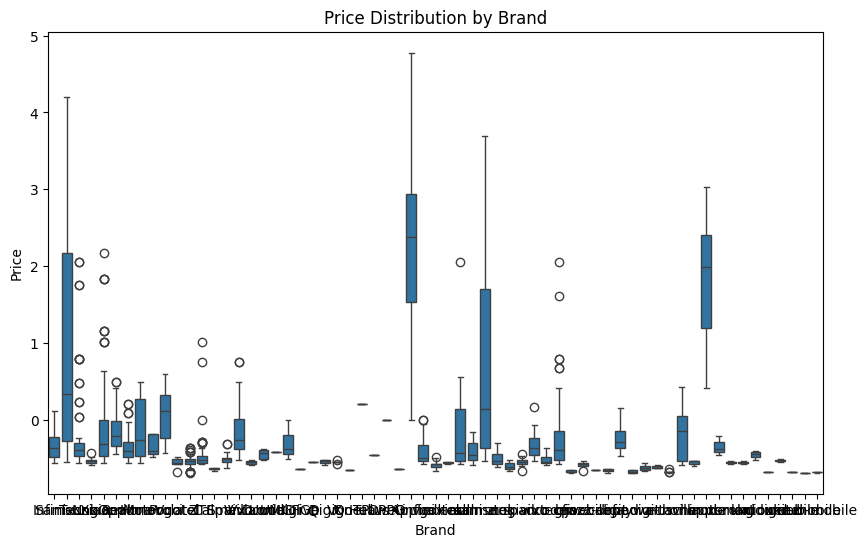


Grouped by Model:
                        mean    median  std
Model                                      
12                  0.635193  0.635193  0.0
12 4G              -0.260341 -0.260341  0.0
12+ 5G             -0.148399 -0.148399  0.0
12T                -0.001391 -0.001391  NaN
12T Pro            -0.001391 -0.001391  NaN
...                      ...       ...  ...
nubia Focus Pro 5G -0.299893 -0.299893  0.0
nubia Music        -0.521538 -0.521538  0.0
nubia Neo 2        -0.297654 -0.297654  0.0
nubia V60 Design   -0.476761 -0.476761  0.0
smart Nova 5       -0.573777 -0.573777  NaN

[684 rows x 3 columns]


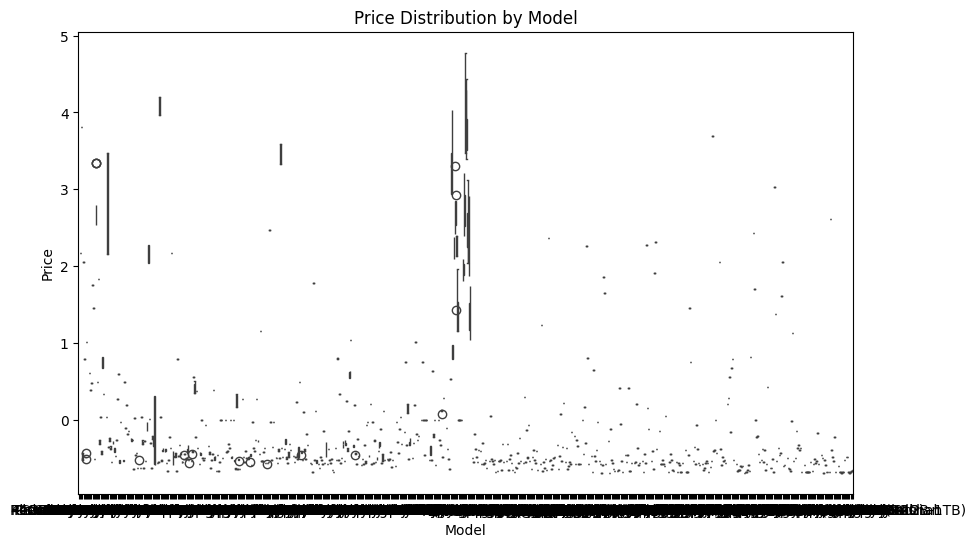

<ipython-input-149-8315777a2f9b>:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Brand', y=target_variable, data=df, palette="muted")


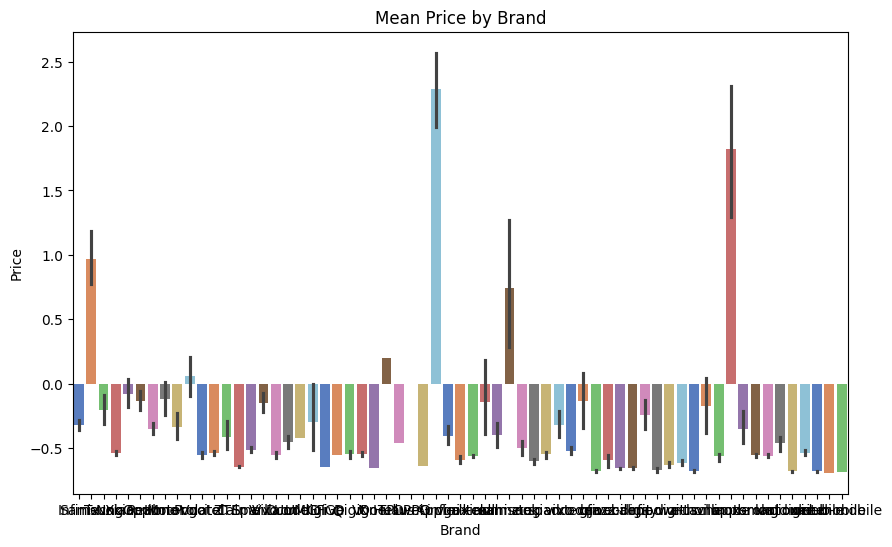

<ipython-input-149-8315777a2f9b>:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y=target_variable, data=df, palette="muted")


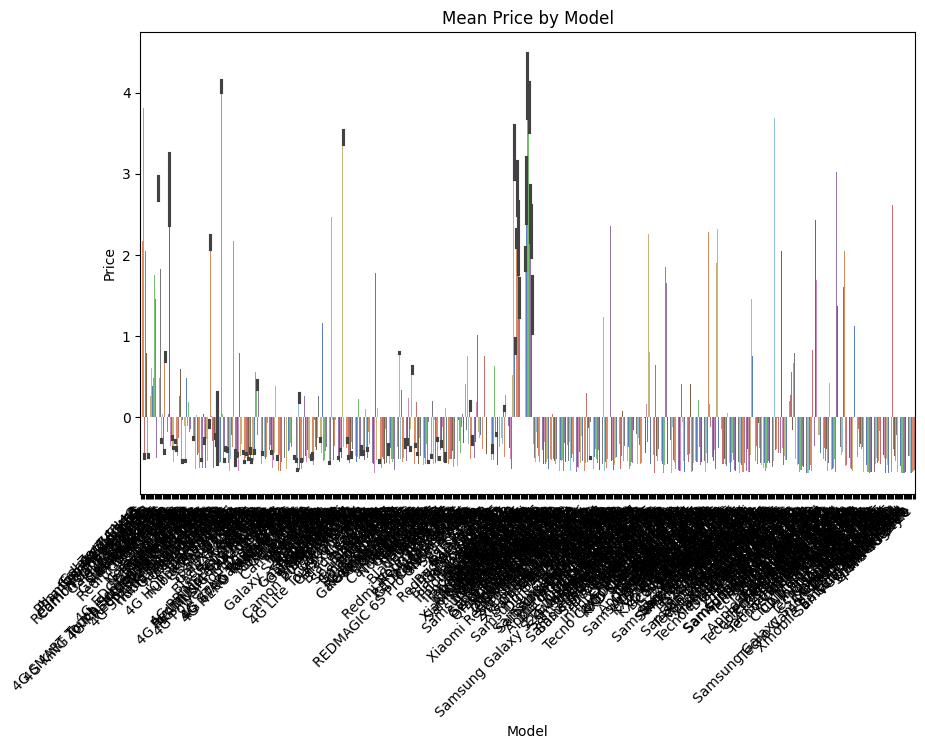

In [149]:
# --- Continuous Features Analysis ---
target_variable = 'Price'

# Correlation analysis between continuous features and the target variable
continuous_features = ['Number of Ratings', 'Display Size', 'RAM', 'Battery', 'Internal Memory']
correlation_with_target = df[continuous_features + [target_variable]].corr()[target_variable]

print("Correlation with Target (Price):")
print(correlation_with_target)

# Visualize correlation with the target using a bar plot
plt.figure(figsize=(8, 6))
sns.barplot(x=correlation_with_target.index, y=correlation_with_target.values, palette="Blues_d")
plt.title(f"Correlation of Features with {target_variable}")
plt.xlabel('Features')
plt.ylabel('Correlation with Price')
plt.show()

# Categorical Features Analysis

# Assuming 'Brand' and 'Model' are categorical features, we'll group by and calculate summary statistics
categorical_features = ['Brand', 'Model']

# 2. Group-by summaries (mean and median for the target)
for feature in categorical_features:
    print(f"\nGrouped by {feature}:")
    grouped_summary = df.groupby(feature)[target_variable].agg(['mean', 'median', 'std'])
    print(grouped_summary)

    plt.figure(figsize=(10, 6))
    sns.boxplot(x=feature, y=target_variable, data=df)
    plt.title(f"{target_variable} Distribution by {feature}")
    plt.xlabel(feature)
    plt.ylabel(target_variable)
    plt.show()

# Additional visualizations for categorical features

# Visualize mean target value by Brand
plt.figure(figsize=(10, 6))
sns.barplot(x='Brand', y=target_variable, data=df, palette="muted")
plt.title(f"Mean {target_variable} by Brand")
plt.xlabel('Brand')
plt.ylabel(target_variable)
plt.show()

# Visualize mean target value by Model
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y=target_variable, data=df, palette="muted")
plt.title(f"Mean {target_variable} by Model")
plt.xticks(rotation=45, ha='right')
plt.xlabel('Model')
plt.ylabel(target_variable)
plt.show()

<h1><b>Data Science Deliverable 3

In [150]:
!pip install keras

In [151]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from keras.models import Sequential
from keras.layers import Dense, Dropout
import matplotlib.pyplot as plt
from IPython.display import display

In [152]:
unique_brands = df['Brand'].unique()
print(unique_brands)

['Infinix' 'Samsung' 'Tecno' 'Nokia' 'Xiaomi' 'Oppo' 'Realme' 'Honor'
 'Motorola' 'Poco' 'Vgotel' 'itel' 'ZTE' 'Calme' 'Sparx' 'Vivo' 'Villaon'
 'Dcode' 'Umidigi' 'UMIDIGI' 'GFive' 'Q' 'Digit' 'X' 'VgoTel' 'OnePlus'
 'Huawei' 'OPPO' 'G' 'Apple' 'infinix' 'vgo-tel' 'all-call' 'xiaomi'
 'realme' 'samsung' 'zte' 'nokia' 'sparx' 'vivo' 'dcode' 'tecno' 'gfive'
 'qmobile' 'jazz-digit' 'calme' 'oppo' 'faywa' 'digit' 'vnus' 'e-tachi'
 'honor' 'villaon' 'apple' 'motorola' 'xsmart' 'kxd' 'umidigi' 'gionee'
 'oukitel' 'xmobile' 'me-mobile' 'club-mobile']


In [153]:
# Assign numerical categories to each brand
brand_to_category = {brand: idx for idx, brand in enumerate(unique_brands)}

display(brand_to_category)

# Print the mapping for documentation and understanding
print("Brand to Category Mapping:", brand_to_category)

# Replace brand names in the 'Brand' column with numerical categories
df.loc[:, 'Brand'] = df['Brand'].map(brand_to_category)

# Verify the updated DataFrame
display(df.head())

df.to_csv('updated_file.csv', index=False)

{'Infinix': 0,
 'Samsung': 1,
 'Tecno': 2,
 'Nokia': 3,
 'Xiaomi': 4,
 'Oppo': 5,
 'Realme': 6,
 'Honor': 7,
 'Motorola': 8,
 'Poco': 9,
 'Vgotel': 10,
 'itel': 11,
 'ZTE': 12,
 'Calme': 13,
 'Sparx': 14,
 'Vivo': 15,
 'Villaon': 16,
 'Dcode': 17,
 'Umidigi': 18,
 'UMIDIGI': 19,
 'GFive': 20,
 'Q': 21,
 'Digit': 22,
 'X': 23,
 'VgoTel': 24,
 'OnePlus': 25,
 'Huawei': 26,
 'OPPO': 27,
 'G': 28,
 'Apple': 29,
 'infinix': 30,
 'vgo-tel': 31,
 'all-call': 32,
 'xiaomi': 33,
 'realme': 34,
 'samsung': 35,
 'zte': 36,
 'nokia': 37,
 'sparx': 38,
 'vivo': 39,
 'dcode': 40,
 'tecno': 41,
 'gfive': 42,
 'qmobile': 43,
 'jazz-digit': 44,
 'calme': 45,
 'oppo': 46,
 'faywa': 47,
 'digit': 48,
 'vnus': 49,
 'e-tachi': 50,
 'honor': 51,
 'villaon': 52,
 'apple': 53,
 'motorola': 54,
 'xsmart': 55,
 'kxd': 56,
 'umidigi': 57,
 'gionee': 58,
 'oukitel': 59,
 'xmobile': 60,
 'me-mobile': 61,
 'club-mobile': 62}

Brand to Category Mapping: {'Infinix': 0, 'Samsung': 1, 'Tecno': 2, 'Nokia': 3, 'Xiaomi': 4, 'Oppo': 5, 'Realme': 6, 'Honor': 7, 'Motorola': 8, 'Poco': 9, 'Vgotel': 10, 'itel': 11, 'ZTE': 12, 'Calme': 13, 'Sparx': 14, 'Vivo': 15, 'Villaon': 16, 'Dcode': 17, 'Umidigi': 18, 'UMIDIGI': 19, 'GFive': 20, 'Q': 21, 'Digit': 22, 'X': 23, 'VgoTel': 24, 'OnePlus': 25, 'Huawei': 26, 'OPPO': 27, 'G': 28, 'Apple': 29, 'infinix': 30, 'vgo-tel': 31, 'all-call': 32, 'xiaomi': 33, 'realme': 34, 'samsung': 35, 'zte': 36, 'nokia': 37, 'sparx': 38, 'vivo': 39, 'dcode': 40, 'tecno': 41, 'gfive': 42, 'qmobile': 43, 'jazz-digit': 44, 'calme': 45, 'oppo': 46, 'faywa': 47, 'digit': 48, 'vnus': 49, 'e-tachi': 50, 'honor': 51, 'villaon': 52, 'apple': 53, 'motorola': 54, 'xsmart': 55, 'kxd': 56, 'umidigi': 57, 'gionee': 58, 'oukitel': 59, 'xmobile': 60, 'me-mobile': 61, 'club-mobile': 62}


,Brand,Model,Price,Number of Ratings,Display Size,RAM,Battery,Internal Memory
0,0,Zero 40 4G,-0.185713,0.021234,0.863694,0.046984,-0.296048,0.023222
1,1,Galaxy Z Flip 6,2.165063,0.037412,0.853503,0.267772,-0.079742,0.046444
2,1,Galaxy Z Fold 6,3.806875,0.043478,0.968153,0.267772,-0.055021,0.046444
3,1,Galaxy A05,-0.521538,0.054601,0.853503,-0.173803,-0.017940,0.005805
4,2,Phantom V Fold 2 5G,2.053122,0.035389,1.000000,0.267772,0.028411,0.046444


<h1><b>Purpose of this deliverable:
<h1><b>Create a model for determining the price of a phone given its brand.

In [154]:
# removing the model name as there are many variations and the name itself does not help in determining the brand of the phone

df = df.drop('Model', axis=1)

df.to_csv('updated_file.csv', index=False)

Selected Features using Correlation Analysis:
['Internal Memory', 'Display Size', 'RAM', 'Brand', 'Number of Ratings']


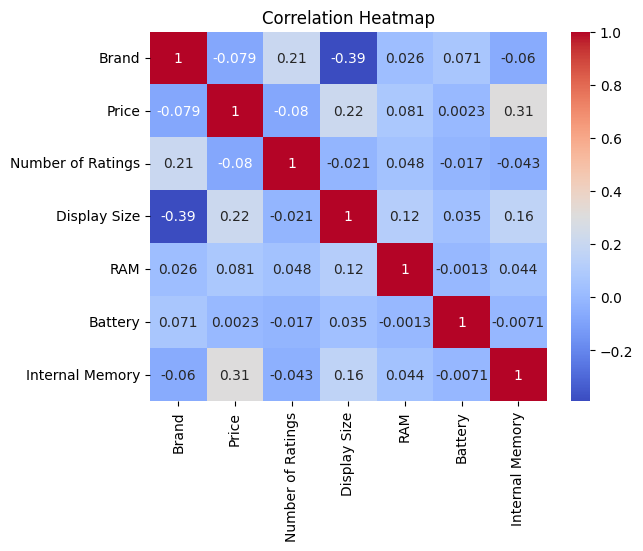

In [175]:
# Compute correlation matrix
correlation_matrix = df.corr()

correlation_with_target = correlation_matrix['Price'].sort_values(ascending=False)

selected_features_corr = correlation_with_target[abs(correlation_with_target) > 0.06].index.tolist()   # clearly we can see that price is heaviliy dependent on internal memory and display size and other features play a minimal role in predicting price

# Drop 'Price' itself as it’s the target
selected_features_corr.remove('Price')

print("Selected Features using Correlation Analysis:")
print(selected_features_corr)

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()


In [184]:
# Define target and features
X = df.drop(columns=['Price'])
y = df['Price']

# Use RandomForestRegressor for RFE
rf = RandomForestRegressor(random_state=42)

# Recursive Feature Elimination (select top 5 features)
rfe = RFE(estimator=rf, n_features_to_select=4)
rfe.fit(X, y)

# Get selected features
selected_features_rfe = X.columns[rfe.support_].tolist()

print("Selected Features using RFE:")
print(selected_features_rfe)


Selected Features using RFE:
['Display Size', 'RAM', 'Battery', 'Internal Memory']


Features Selected by Correlation Analysis:
['Internal Memory', 'Display Size', 'RAM', 'Brand', 'Number of Ratings']

Features Selected by RFE:
['Display Size', 'RAM', 'Battery', 'Internal Memory']

Common Features:
{'RAM', 'Internal Memory', 'Display Size'}


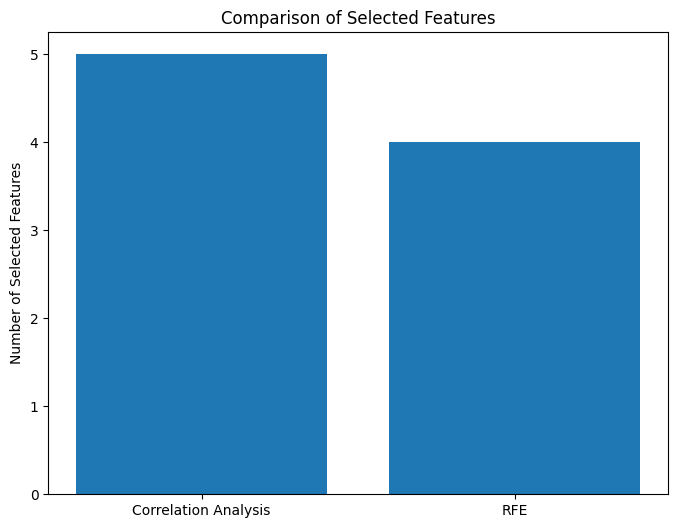

In [185]:
# Compare selected features
print("Features Selected by Correlation Analysis:")
print(selected_features_corr)

print("\nFeatures Selected by RFE:")
print(selected_features_rfe)

# Find common features
common_features = set(selected_features_corr).intersection(selected_features_rfe)
print("\nCommon Features:")
print(common_features)

# Visualize the comparison
plt.figure(figsize=(8, 6))
plt.bar(['Correlation Analysis', 'RFE'], [len(selected_features_corr), len(selected_features_rfe)])
plt.ylabel('Number of Selected Features')
plt.title('Comparison of Selected Features')
plt.show()


In [186]:
X_filtered = X[list(common_features)]

# Display the filtered DataFrame
print("\nFiltered DataFrame with Common Features:")
print(X_filtered.head())


Filtered DataFrame with Common Features:
        RAM  Internal Memory  Display Size
0  0.046984         0.023222      0.863694
1  0.267772         0.046444      0.853503
2  0.267772         0.046444      0.968153
3 -0.173803         0.005805      0.853503
4  0.267772         0.046444      1.000000


In [187]:
X_selected = rfe.fit_transform(X_filtered, y)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_rfe.py:291: UserWarning: Found n_features_to_select=4 > n_features=3. There will be no feature selection and all features will be kept.
  warnings.warn(


In [200]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

# Random Forest Regressor
rf = RandomForestRegressor()
rf.fit(X_train, y_train)

# Neural Network
model = Sequential()
model.add(Dense(128, activation='relu', input_dim=X_train.shape[1]))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='linear'))
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Random Forest - MSE: 0.22972430612683883, R²: 0.6962995966520331
Neural Network - MSE: 0.7818192463390743, R²: -0.033581619906088545


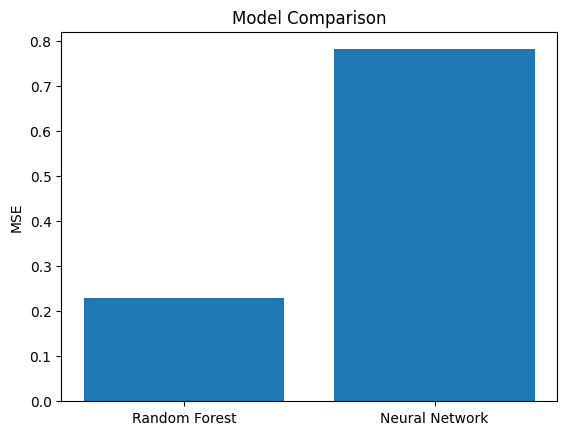

In [201]:
# Random Forest Predictions
y_pred_rf = rf.predict(X_test)

# Neural Network Predictions
y_pred_nn = model.predict(X_test)

# Metrics
rf_mse = mean_squared_error(y_test, y_pred_rf)
rf_r2 = r2_score(y_test, y_pred_rf)
print(f"Random Forest - MSE: {rf_mse}, R²: {rf_r2}")

nn_mse = mean_squared_error(y_test, y_pred_nn)
nn_r2 = r2_score(y_test, y_pred_nn)
print(f"Neural Network - MSE: {nn_mse}, R²: {nn_r2}")

# Visualization
plt.bar(['Random Forest', 'Neural Network'], [rf_mse, nn_mse])
plt.ylabel('MSE')
plt.title('Model Comparison')
plt.show()


In [202]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# Define the model
rf = RandomForestRegressor(random_state=42)

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2'],
    'bootstrap': [True, False]
}

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

# Fit the model
grid_search.fit(X_train, y_train)

# Best parameters found by GridSearchCV
print("Best parameters found: ", grid_search.best_params_)

# Evaluate the model with the best parameters
best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(X_test)

# Evaluate performance
from sklearn.metrics import mean_squared_error, r2_score
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"MSE: {mse}, R²: {r2}")


Fitting 5 folds for each of 648 candidates, totalling 3240 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
1080 fits failed out of a total of 3240.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1080 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/u

Best parameters found:  {'bootstrap': True, 'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
MSE: 0.22608426710730062, R²: 0.7011118054125016
